In [1]:
from PathALAE.models import *
from PathALAE.optimizers import *
from PathALAE.data import *
from PathALAE.utils import *

import matplotlib.pyplot as plt

In [2]:
fname = "/home/simon/PycharmProjects/StyleALAE/StyleALAE/configs/celeba_hq_256.yaml"
config = ConfigParser(fname)
print(dir(config))

['D_layers', 'F_layers', 'alpha', 'base_features', 'batch_sizes', 'block_type', 'data_dir', 'filters', 'gammas', 'k_images', 'levels', 'n', 'resume_level', 'run_dir', 'z_dim']


In [5]:
# Parameters
Z_DIM = 200
MAPPING_LAYERS = 3

BASE_DIM = (8, 8, 256)
IMG_DIM = 128
BATCH_SIZE = 8

FILTERS = [256, 128, 128, 64, 32, 16]

DATA_DIR = f"/home/simon/Documents/Programming/Data/progressive_growing_of_gans/celeba-hq/celeba-{IMG_DIM}"

In [6]:
data_gen, N = create_data_set(data_directory=DATA_DIR, img_dim=IMG_DIM, batch_size=BATCH_SIZE)
print("Num Images:", N)

Num Images: 30000


In [7]:
# # --- MULTI-GPU TRAINING --- #
# strategy = tf.distribute.Strategy()
# print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
# # Everything that creates variables should be under the strategy scope.
# with strategy.scope():
    
    
# Build subnetworks
F = MappingResidual(z_dim=Z_DIM, n_layers=MAPPING_LAYERS)

G = build_demod_generator(z_dim=Z_DIM,
                image_dim=IMG_DIM,
                base_dim=BASE_DIM,
                filters=FILTERS,
                attention_level=3
               )

E = build_encoder(z_dim=Z_DIM,
                image_dim=IMG_DIM,
                filters=FILTERS,
                attention_level=3)

D = DiscriminatorResidual(z_dim=Z_DIM, n_layers=3)


# Combine into ALAE
alae = ALAE(x_dim=IMG_DIM,
        z_dim=Z_DIM,
        f_model=F,
        g_model=G,
        e_model=E,
        d_model=D,
        merge=False,
        style_mix_step=16)

# Optimizers
Adam_D, Adam_G, Adam_R = create_optimizers(α=0.001, β1=0.0, β2=0.99)


In [10]:
# Prepare for training
alae.compile(d_optimizer=Adam_D,
             g_optimizer=Adam_G,
             r_optimizer=Adam_R,
             γ=0.1,
             alpha_step=None)

In [9]:
E.summary()

Model: "E"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
EncBlock_0_Conv (Conv2DEQ)   (None, 128, 128, 16)      448       
_________________________________________________________________
EncBlock_0_act (LeakyReLU)   (None, 128, 128, 16)      0         
_________________________________________________________________
E_block_1_encoder (ResidualB (None, 128, 128, 16)      4768      
_________________________________________________________________
E_block_0_DownSample (Averag (None, 64, 64, 16)        0         
_________________________________________________________________
EncBlock_1_UpConv (Conv2DEQ) (None, 64, 64, 32)        4640      
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 64, 32)        128       

In [7]:
EPOCHS = int(400_000 / N ); EPOCHS
STEPS = N // BATCH_SIZE
print("Epochs:", EPOCHS)

IMG_DIR = "./output"
WEIGHT_DIR = "./weights"
LOG_DIR = "./logs"

Epochs: 13


In [8]:
# Call back
test_z = tf.random.normal((8, Z_DIM))
test_batch = get_test_batch(data_gen)

# TRAINING
callbacks = [
    Summary(log_dir=LOG_DIR,
            write_graph=False,
            update_freq=50,  # every n batches
            test_z=test_z,
            test_batch=test_batch,
            img_dir=IMG_DIR,
            n=8,
            weight_dir=WEIGHT_DIR
            )
]

In [9]:
history = alae.fit(x=data_gen,
                   steps_per_epoch=STEPS,
                   epochs=100,
                   callbacks=callbacks
                   )

Epoch 1/100
3750/3750 [==============================] - ETA: 0s - loss_d: 0.9077 - loss_g: 5.2187 - loss_r: 6.1997 - loss_gp: 0.8236
Plot saved at ./output/progress_0064_0000.jpg
Weights Saved. -  ./weights/Epoch_-01
3750/3750 [==============================] - 543s 145ms/step - loss_d: 0.9077 - loss_g: 5.2187 - loss_r: 6.1997 - loss_gp: 0.8239
Epoch 2/100
3750/3750 [==============================] - ETA: 0s - loss_d: 1.1872 - loss_g: 4.2165 - loss_r: 4.5804 - loss_gp: 4.8762
Plot saved at ./output/progress_0064_0001.jpg
Weights Saved. -  ./weights/Epoch_-01
3750/3750 [==============================] - 543s 145ms/step - loss_d: 1.1872 - loss_g: 4.2165 - loss_r: 4.5804 - loss_gp: 4.8765
Epoch 3/100
3750/3750 [==============================] - ETA: 0s - loss_d: 1.2582 - loss_g: 3.9795 - loss_r: 3.8730 - loss_gp: 7.5231
Plot saved at ./output/progress_0064_0002.jpg
Weights Saved. -  ./weights/Epoch_-01
3750/3750 [==============================] - 543s 145ms/step - loss_d: 1.2582 - loss_g

Epoch 24/100
3750/3750 [==============================] - ETA: 0s - loss_d: 1.4189 - loss_g: 3.7385 - loss_r: 1.5764 - loss_gp: 13.2443
Plot saved at ./output/progress_0064_0023.jpg
Weights Saved. -  ./weights/Epoch_-01
3750/3750 [==============================] - 538s 143ms/step - loss_d: 1.4189 - loss_g: 3.7385 - loss_r: 1.5764 - loss_gp: 13.2443
Epoch 25/100
3750/3750 [==============================] - ETA: 0s - loss_d: 1.4401 - loss_g: 3.5291 - loss_r: 1.5345 - loss_gp: 12.7555
Plot saved at ./output/progress_0064_0024.jpg
Weights Saved. -  ./weights/Epoch_-01
3750/3750 [==============================] - 538s 143ms/step - loss_d: 1.4401 - loss_g: 3.5291 - loss_r: 1.5345 - loss_gp: 12.7555
Epoch 26/100
3750/3750 [==============================] - ETA: 0s - loss_d: 1.5124 - loss_g: 3.2442 - loss_r: 1.5247 - loss_gp: 13.1928
Plot saved at ./output/progress_0064_0025.jpg
Weights Saved. -  ./weights/Epoch_-01
3750/3750 [==============================] - 538s 143ms/step - loss_d: 1.5124 

Epoch 70/100
3750/3750 [==============================] - ETA: 0s - loss_d: 1.2863e-10 - loss_g: 48.3316 - loss_r: 3.1373 - loss_gp: 2.5963e-12
Plot saved at ./output/progress_0064_0069.jpg
Weights Saved. -  ./weights/Epoch_-01
3750/3750 [==============================] - 538s 143ms/step - loss_d: 1.2863e-10 - loss_g: 48.3316 - loss_r: 3.1373 - loss_gp: 2.5961e-12
Epoch 71/100
3750/3750 [==============================] - ETA: 0s - loss_d: 3.3949e-04 - loss_g: 63.5058 - loss_r: 3.3051 - loss_gp: 1.5476e-12
Plot saved at ./output/progress_0064_0070.jpg
Weights Saved. -  ./weights/Epoch_-01
3750/3750 [==============================] - 538s 143ms/step - loss_d: 3.3949e-04 - loss_g: 63.5058 - loss_r: 3.3051 - loss_gp: 1.5477e-12
Epoch 72/100
3750/3750 [==============================] - ETA: 0s - loss_d: 4.9210e-10 - loss_g: 51.2533 - loss_r: 3.4587 - loss_gp: 2.5678e-12
Plot saved at ./output/progress_0064_0071.jpg
Weights Saved. -  ./weights/Epoch_-01
3750/3750 [===========================

Weights Saved. -  ./weights/Epoch_-01
3750/3750 [==============================] - 538s 143ms/step - loss_d: 1.7939e-07 - loss_g: 99.9220 - loss_r: 4.7243 - loss_gp: 2.3619e-15
Epoch 93/100
3750/3750 [==============================] - ETA: 0s - loss_d: 6.2993e-16 - loss_g: 102.0202 - loss_r: 3.2061 - loss_gp: 1.4909e-14
Plot saved at ./output/progress_0064_0092.jpg
Weights Saved. -  ./weights/Epoch_-01
3750/3750 [==============================] - 538s 143ms/step - loss_d: 6.2993e-16 - loss_g: 102.0202 - loss_r: 3.2061 - loss_gp: 1.4908e-14
Epoch 94/100
3750/3750 [==============================] - ETA: 0s - loss_d: 1.1917e-15 - loss_g: 96.9848 - loss_r: 3.4247 - loss_gp: 7.0550e-15
Plot saved at ./output/progress_0064_0093.jpg
Weights Saved. -  ./weights/Epoch_-01
3750/3750 [==============================] - 538s 143ms/step - loss_d: 1.1917e-15 - loss_g: 96.9848 - loss_r: 3.4247 - loss_gp: 7.0541e-15
Epoch 95/100
1786/3750 [=============>................] - ETA: 4:48 - loss_d: 0.0433 - 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/simon/anaconda3/envs/tf2/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-cbcee5ac921b>", line 4, in <module>
    callbacks=callbacks
  File "/home/simon/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py", line 66, in _method_wrapper
    return method(self, *args, **kwargs)
  File "/home/simon/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py", line 848, in fit
    tmp_logs = train_function(iterator)
  File "/home/simon/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/eager/def_function.py", line 580, in __call__
    result = self._call(*args, **kwds)
  File "/home/simon/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/eager/def_function.py", line 611, in _call
    return self._stateless_fn(*args, **kwds)  # pylin

KeyboardInterrupt: 

In [12]:
g_loss = [5.2187,
4.2165,
3.9795,
3.5990,
3.6818,
3.8519,
4.0629,
4.0924,
3.9742,
3.9271,
3.6910,
4.4944,
4.9695,
4.3506,
4.7048,
4.8405,
4.0644,
3.8624,
3.5032,
3.6576,
3.6716,
4.3552,
4.0681,
3.7385,
3.5291,
3.2442,
3.1894,
2.9873,
2.8917,
2.8572,
2.8625,
2.8004,
2.7325,
2.0342]

In [13]:
d_loss = [0.9077,
1.1872,
1.2582,
1.4275,
1.4445,
1.4186,
1.4198,
1.4467,
1.5279,
1.5742,
1.6298,
1.2720,
1.1496,
1.3485,
1.2056,
1.1918,
1.4488,
1.4994,
1.5545,
1.4978,
1.4668,
1.3060,
1.3877,
1.4189,
1.4401,
1.5124,
1.5057,
1.5707,
1.5601,
1.5758,
1.5864,
1.6185,
1.6577,
7.7717]

In [14]:
r_loss = [6.1997,
4.5804,
3.8730,
3.5060,
3.2580,
3.1053,
2.9546,
2.8275,
2.6734,
2.5239,
2.4207,
2.3608,
2.3319,
2.2476,
2.1438,
2.1129,
2.0468,
1.9681,
1.9560,
1.7983,
1.7943,
1.6972,
1.6052,
1.5764,
1.5345,
1.5247,
1.4630,
1.4689,
1.3758,
1.3704,
1.3445,
1.3120,
1.2856,
1.2854]

In [19]:
gp_loss = [0.8239,
4.8765,
7.5233,
9.4957,
10.777,
11.343,
11.893,
12.669,
13.743,
14.232,
14.653,
13.368,
12.004,
13.830,
13.137,
13.443,
14.241,
14.688,
14.243,
13.559,
13.095,
13.010,
13.256,
13.244,
12.755,
13.192,
12.650,
13.308,
13.075,
12.635,
12.709,
13.083,
12.943,
54.609]

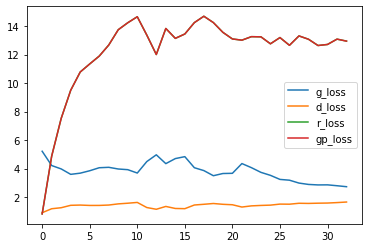

In [26]:
n = 33
plt.plot(range(n), g_loss[:n], label="g_loss")
plt.plot(range(n), d_loss[:n], label="d_loss")
plt.plot(range(n), r_loss[:n], label="r_loss")
plt.plot(range(n), gp_loss[:n], label="gp_loss")
plt.legend()
plt.show()